# Lab 5: Manufacturing Inspection
Task: In this assignment you will apply image processing techniques to determine the level of liquid in a bottle. You can create a class `FluidLevelDetector` which will contain a method `detect_fluid_levels` which will return a series of horizontal lines correponding to the fluid level in the bottles on the image. These lines can then be marked on the image as shown.

![link text](https://github.com/tonyscan6003/etivities/blob/main/manu_inspect.JPG?raw=true)








## Methodology
Your Class can use the suggested methodology below (or use an alternative). Each of the steps can be used to produce a class instance instance variable, that you can access and view to determine if your class is correctly operating.

1. Threshold the image and apply a closing operation.
2. Apply the Canny Algorithm to find edges.
3. Use a mask on region of interest (where fluid levels are)
4. Use the Hough algorithm to find lines corresponding to edges.
5. Find the horizontal lines corresponding to fluid levels and output.

Notes:
> The [OpenCV2 Threshold](https://docs.opencv.org/4.5.1/d7/d4d/tutorial_py_thresholding.html) operation to the input grayscale image producing a binary image of the bottles. (Note that it is better to use the CV.THRESH_BINARY_INV option as this makes the bottle edge white and the fluid black after the threshold operation)

> The [OpenCV2 closing operation](https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html) is then used to make to help remove some of the holes in the image and noise around the edges.

> The OpenCV implementation of the [Canny Algorithm](https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html) can be used to find edges in binary images of the bottles we have just produced.

> We use a mask to select a region of interest around the fluid levels. The part of the image inside the region is retained and the rest of the image is removed (set to zero). This masking process is useful as it allows us to remove horizonatal edges due to the bottle cap or bottle base that could be confused with the fluid level.
> * Initally define a blank mask the same size as the input image. (The numpy function [zeros_like](https://numpy.org/doc/stable/reference/generated/numpy.zeros_like.html) is a quick way to do this.)
* The region of interest (white pixels) can be added to the mask using the cv2.fillPoly method that can create a a filled rectangular region.
* The shape of the region is determined by the number of vertices applied to the cv2.fillPoly method. If a rectangle is required then 4 vertices are needed. (we create the vertices in the next code cell)
* The mask can be applied the binary image (edges image) the [cv2.bitwise_and](https://docs.opencv.org/4.x/d0/d86/tutorial_py_image_arithmetics.html) method can be used.

> The Hough Transform is used to convert (Edges) points to lines in the image.
*   [Hough Algorithm](https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html) (example of use)

> We have detected horizontal lines corresponding to the fluid but also many vertical lines corresponding to the bottle edges.
We can simply remove distracting vertical edges by just finding horizonal lines which have small slopes m close to 0.
* Take care when computing slopes that the slope could return nan if the lines is vertical.You can modify you code to take of these exceptions.

#Housekeeping:
Import packages, read test image, define helper functions.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import urllib.request
import os
from urllib.parse import urlparse

In [2]:
# function to read images from Web addresses.
def download_image(url, save_path):
    """
    Downloads an image from a URL and saves it to disk.
    If the image already exists at the specified path, it is read from disk.

    Args:
        url (str): URL of the image.
        save_path (str): Path to save the image on disk.

    Returns:
        None
    """
    # Parse the URL to get the filename
    filename = os.path.basename(urlparse(url).path)
    image_path = os.path.join(save_path, filename)

    # Check if the image already exists
    if os.path.exists(image_path):
        print(f"Image already exists at {image_path}. Reading from disk.")
        image = cv2.imread(image_path)
    else:
        print(f"Downloading image from {url}...")
        resp = urllib.request.urlopen(url)
        temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
        temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
        temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
        print(f"Image downloaded and saved at {image_path}.")
        cv2.imwrite(image_path, temp_image)
        image = cv2.imread(image_path)
    return image

# Function to normalise images for display
def norm_img(ip_img):
   norm_img = ip_img-np.min(ip_img)
   norm_img = norm_img/(np.max(ip_img)-np.min(ip_img))
   return norm_img

# Create Class

You can create the class `FluidLevelDetector` and the associated method  `detect_fluid_levels` in the code cell below.
> **Note 1:** Your class should contain default values for any arguments introduced into your class init statment. During testing by code grade (and in evaluation code below) no input arguments will be applied during the creation of an instance of the class.
  `detector = FluidLevelDetector()`
  The skeleton code below shows an example of including an input argument for the theshold value required by the openCV threshold operation.

> Additionally during testing the call to the detect fluid levels will should only contain the image as an input
`horizontal_lines = detector.detect_fluid_levels(image)`

> **Note 2:** To structure your code you can encapsulate each image processing step (e.g Thresholding) within a method and combine these methods within the final FluidLevelDetector() method. As there are many intermediate steps required in this lab, you may wish to view the results of these intermediate steps. The best approach is to assign instance variables (e.g. `self.instancename`) to the output of each method call, these can then be simply accessed as `instancename.classname` in your evaluation code (after the fluid detector method is run).  





In [3]:
class FluidLevelDetector:
    def __init__(self,threshold_value=240):

        # Intermediate outputs
        self.thresholded = None # Initialise but assign later
        self.threshold_value = threshold_value
        self.closed_image = None
        self.canny_edges = None
        self.masked_image = None
        self.horizontal_lines = []

    #### Your code here ####
    def apply_threshold(self, gray_img):
        ret, self.thresholded = cv2.threshold(gray_img, self.threshold_value, 255, cv2.THRESH_BINARY_INV)
        return self.thresholded
    def apply_closing(self):
        kernel = np.ones((5,5),np.uint8)
        self.closed_image = cv2.morphologyEx(self.thresholded, cv2.MORPH_CLOSE, kernel)
        return self.closed_image
    def detect_edges(self):
        low_threshold,high_threshold=80,240
        self.canny_edges = cv2.Canny(self.closed_image, low_threshold, high_threshold)
        return self.canny_edges
    def apply_mask(self):
        h, w = self.canny_edges.shape
        mask = np.zeros_like(self.canny_edges)
        points = np.array([[int(0.05*w), int(0.15*h)], [int(0.05*w), int(0.4*h)],[int(0.95*w), int(0.39*h)],  [int(0.95*w), int(0.15*h)]])
        cv2.fillPoly(mask, [points], color=255)
        self.masked_image = cv2.bitwise_and(self.canny_edges, mask)
        return self.masked_image
    def detect_horizontal_lines(self):
        rho_res = 1
        theta_res = np.pi / 180
        threshold = 20
        min_line_len = 30
        max_line_gap = 5
        lines = cv2.HoughLinesP(self.masked_image, rho_res, theta_res, threshold, np.array([]),minLineLength=min_line_len, maxLineGap=max_line_gap)
        self.horizontal_lines = []
        if lines is not None:
          for segment in lines:
            x_start, y_start, x_end, y_end = segment[0]
            if x_end != x_start:
              slope = (y_end - y_start) / (x_end - x_start)
              if abs(slope) < 0.1:
                self.horizontal_lines.append(segment)
        return self.horizontal_lines


    def detect_fluid_levels(self, image_gray):
        self.apply_threshold(image_gray)
        self.apply_closing()
        self.detect_edges()
        self.apply_mask()
        self.detect_horizontal_lines()
        return  self.horizontal_lines



# Evaluate

Image already exists at ./NEW_Fill_level_Rounded_Image_660pxh.jpg. Reading from disk.


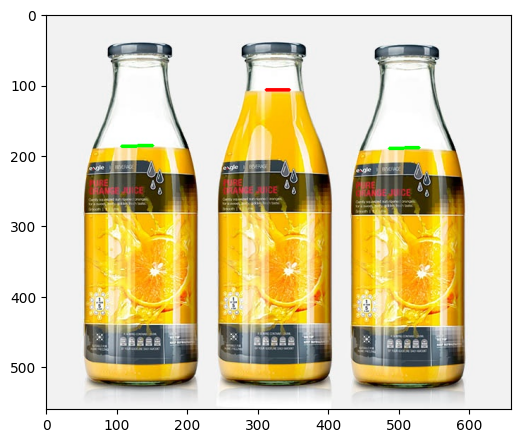

In [4]:
if __name__ == "__main__":

  # Download test image
  image_url = "https://cdn.eaglepi.com/uploads/2016/08/NEW_Fill_level_Rounded_Image_660pxh.jpg"
  image = download_image(image_url,save_path="./")
  # Convert to greyscale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Create detector instance
  detector = FluidLevelDetector()

  # Detect horizontal lines
  horizontal_lines = detector.detect_fluid_levels(gray)

  # Create plot
  f, axarr = plt.subplots(1,1,figsize=(6,6))



  for line in horizontal_lines:
    x1,y1,x2,y2 = line[0]
    y_average = (y2+y1)/2

    blk = np.zeros(image.shape, np.uint8)
    if y_average<150:
        cv2.line(image,(x1,y1),(x2,y2),(255,0,0),3)
    else:
        cv2.line(image,(x1,y1),(x2,y2),(0,255,0),3)
  axarr.imshow(image)



